In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  %cd /content/drive/MyDrive/M5_Project/Week4
  !ls

In [3]:
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.optim import lr_scheduler
import torch.optim as optim

import os
from PIL import Image
import pandas as pd
import numpy as np
import pickle
from torch.utils.data.dataset import Dataset  # For custom datasets

from trainer import fit
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [16]:
import warnings
warnings.filterwarnings('ignore')

# Prepare Dataset

In [4]:
TRAIN_DATA_PATH = "../MIT_split/train/"
TEST_DATA_PATH = "../MIT_split/test/"

batch_size = 128

TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4275, 0.4525, 0.4494],
                         std=[0.2566, 0.2470, 0.2764])
    ])

train_data = ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
test_data = ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)

cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, **kwargs)

n_classes = 8

In [5]:
for X, y in test_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([128, 3, 256, 256])
Shape of y: torch.Size([128]) torch.int64


# Baseline

## Basic EmbeddingNet

In [6]:
# Set up the network and training parameters
from networks import BaselineNet, ClassificationNet_v2
from metrics import AccumulatedAccuracyMetric

embedding_net = BaselineNet()
model = ClassificationNet_v2(embedding_net, n_classes=n_classes)
if cuda:
    model.cuda()
    print('Cuda!!!')
loss_fn = torch.nn.NLLLoss()
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=2,gamma=0.96)
n_epochs = 25
log_interval = 100

Cuda!!!


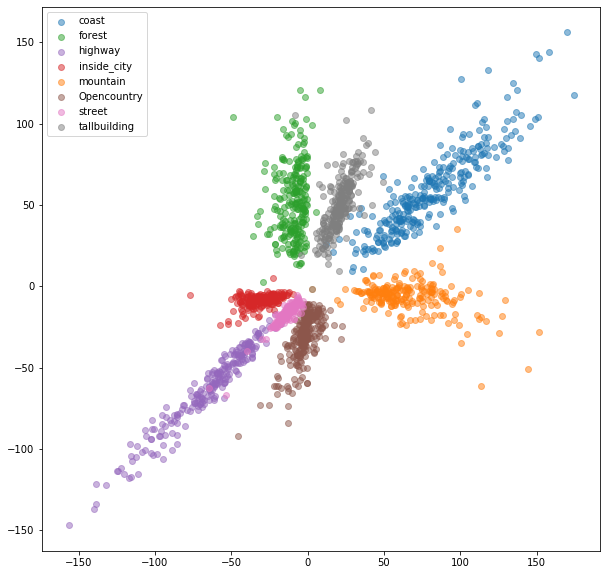

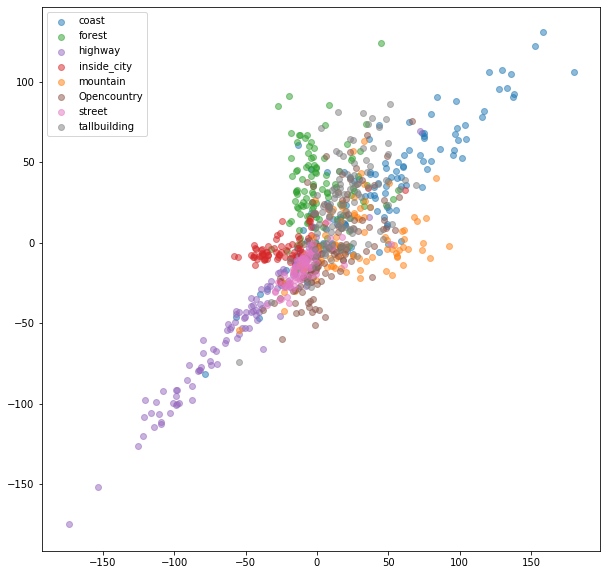

In [8]:
from embeddings_utils import *
train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model, 2)
plot_embeddings(train_embeddings_cl, train_labels_cl, mit_classes, colors)
val_embeddings_cl, val_labels_cl = extract_embeddings(test_loader, model, 2)
plot_embeddings(val_embeddings_cl, val_labels_cl, mit_classes, colors)

# SiameseNet

## Set up

In [5]:
from MITSplitDataSet import MITSplitDataset_v2
cuda = torch.cuda.is_available()

TRAIN_DATA_PATH = "../MIT_split/train_data.csv"
TEST_DATA_PATH = "../MIT_split/test_data.csv"

TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(256),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4275, 0.4525, 0.4494],
                         std=[0.2566, 0.2470, 0.2764])
    ])

TRANSFORM_IMG_TEST = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4275, 0.4525, 0.4494],
                         std=[0.2566, 0.2470, 0.2764])
    ])

In [6]:
# Load dataset
from datasets import SiameseMNIST

# Setup datasets for training
train_data = MITSplitDataset_v2(TRAIN_DATA_PATH, TEST_DATA_PATH, transform=TRANSFORM_IMG, train= True)
test_data = MITSplitDataset_v2(TRAIN_DATA_PATH, TEST_DATA_PATH, transform=TRANSFORM_IMG_TEST, train= False)

siamese_train_dataset = SiameseMNIST(train_data) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseMNIST(test_data)

batch_size = 64
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

printing train data length MIT Split
1881


## Training !

In [19]:
# Set up the network and training parameters
from networks import ModelM3, SiameseNet
from losses import ContrastiveLoss

save_path = 'SiameseNet.pth'

embedding_net = ModelM3()
model = SiameseNet(embedding_net)

if cuda:
    model.cuda()

if not os.path.exists(save_path):
    if cuda:
        model.cuda()
        print('Cuda!!!')

    margin = 1.
    loss_fn = ContrastiveLoss(margin)
    lr = 1e-3
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.9, last_epoch=-1)
    n_epochs = 100
    log_interval = 1000
    ## Training !!!
    fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)
    torch.save(model.state_dict(), save_path)
else:
    print('Loading model...')
    model.load_state_dict(torch.load(save_path))
    model.to(device)

Cuda!!!
Train: [0/1881 (0%)]	Loss: 0.320215
Epoch: 1/100. Train set: Average loss: 0.1510
Epoch: 1/100. Validation set: Average loss: 0.1205
Train: [0/1881 (0%)]	Loss: 0.108667
Epoch: 2/100. Train set: Average loss: 0.1204
Epoch: 2/100. Validation set: Average loss: 0.1133
Train: [0/1881 (0%)]	Loss: 0.110939
Epoch: 3/100. Train set: Average loss: 0.1125
Epoch: 3/100. Validation set: Average loss: 0.1123
Train: [0/1881 (0%)]	Loss: 0.112144
Epoch: 4/100. Train set: Average loss: 0.1084
Epoch: 4/100. Validation set: Average loss: 0.1038
Train: [0/1881 (0%)]	Loss: 0.096226
Epoch: 5/100. Train set: Average loss: 0.1000
Epoch: 5/100. Validation set: Average loss: 0.0978
Train: [0/1881 (0%)]	Loss: 0.096057
Epoch: 6/100. Train set: Average loss: 0.0983
Epoch: 6/100. Validation set: Average loss: 0.0927
Train: [0/1881 (0%)]	Loss: 0.114654
Epoch: 7/100. Train set: Average loss: 0.0951
Epoch: 7/100. Validation set: Average loss: 0.0914
Train: [0/1881 (0%)]	Loss: 0.078048
Epoch: 8/100. Train set: 

In [12]:
## Visualise input
a = None
for X, y in siamese_train_loader:
    a = X
    print(f"Shape of X [N, C, H, W]: {X[0].shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64


## Visualise Embedding

In [20]:
from embeddings_utils import *

# Load embedding
train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model, 256)
test_embeddings_cl, test_labels_cl = extract_embeddings(test_loader, model, 256)

### PCA

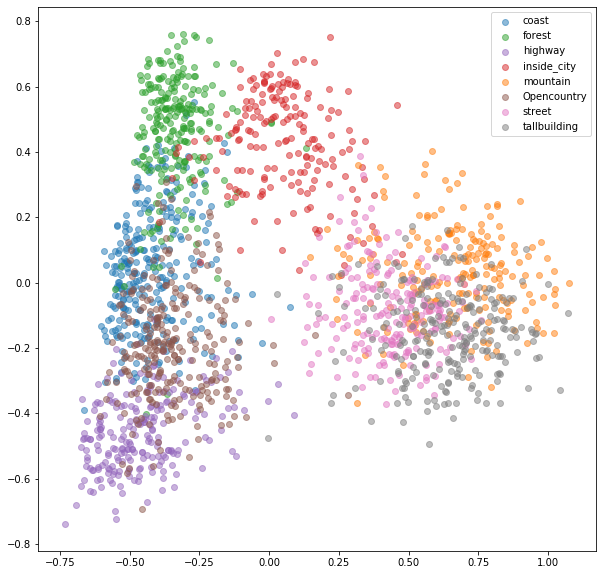

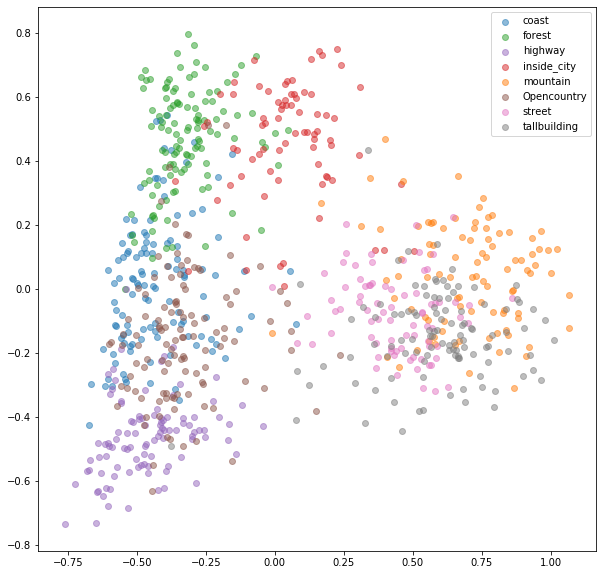

In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
components = pca.fit_transform(train_embeddings_cl)

#train embeddings
plot_embeddings(components, train_labels_cl, mit_classes, colors)

#test embedings
test_comp = pca.transform(test_embeddings_cl)
plot_embeddings(test_comp, test_labels_cl, mit_classes, colors)

### LDA

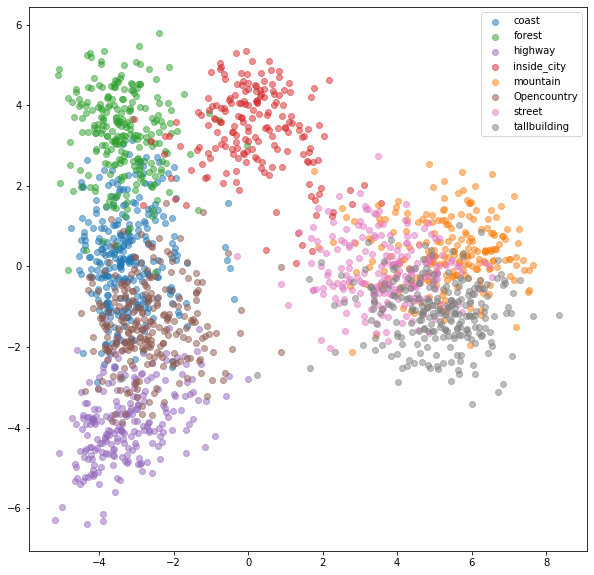

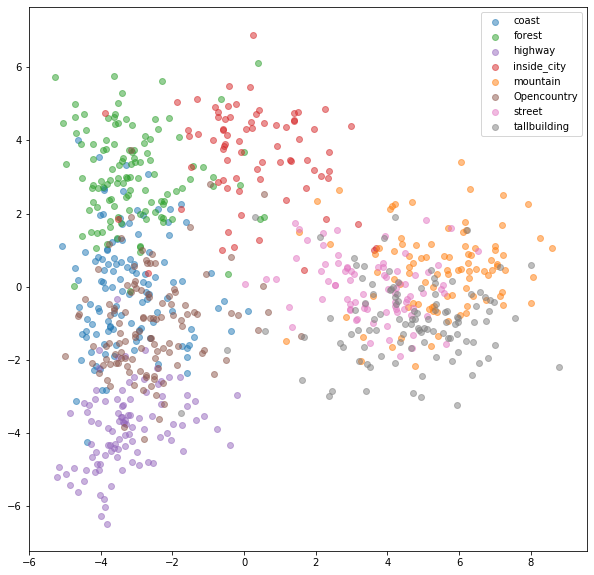

In [22]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()

#train embeddings
lda_embs = lda.fit_transform(train_embeddings_cl, train_labels_cl)
plot_embeddings(lda_embs,train_labels_cl, mit_classes, colors)

#test embeddings
lda_embs_test = lda.transform(test_embeddings_cl)
plot_embeddings(lda_embs_test,test_labels_cl, mit_classes, colors)

### TSNE

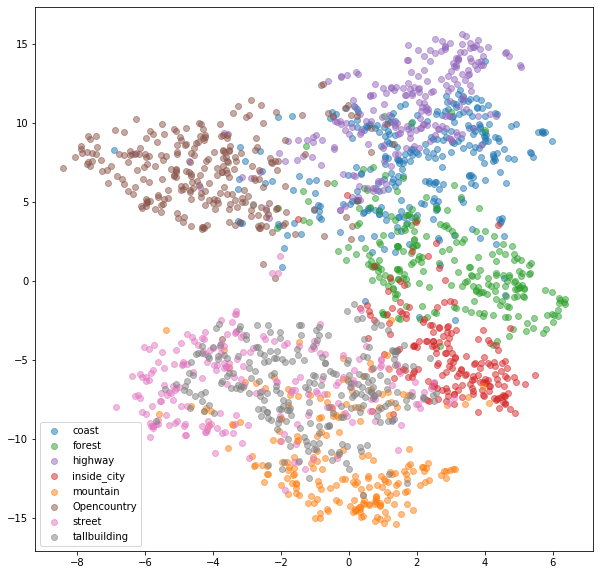

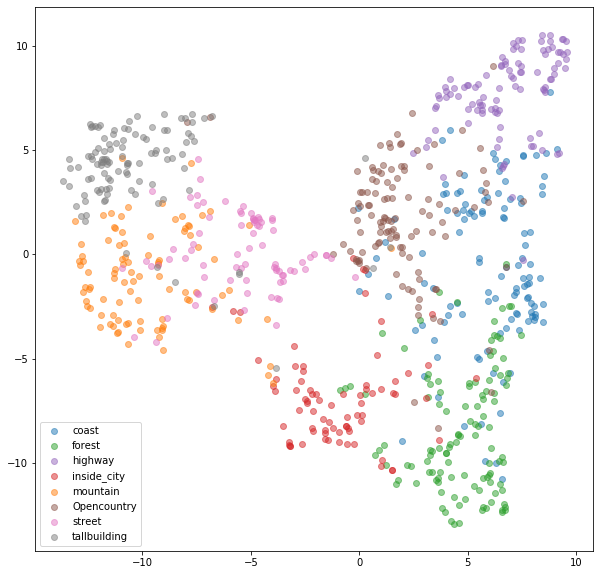

In [23]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, init='random')

embs_reduced = tsne.fit_transform(train_embeddings_cl)
plot_embeddings(embs_reduced,train_labels_cl, mit_classes, colors)

embs_reduced = tsne.fit_transform(test_embeddings_cl)
plot_embeddings(embs_reduced,test_labels_cl, mit_classes, colors)

In [24]:
knn = build_knn(train_embeddings_cl, train_labels_cl, n_classes)
print('KNN Classifier Accuracy: ',100.0 * knn.score(test_embeddings_cl,test_labels_cl))

KNN Classifier Accuracy:  82.15613382899627


In [25]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# precision recall curve
def plot_prec_rec_curve_multiclass(y_gt, y_pred, labels):
    precision = dict()
    recall = dict()
    aps = []
    for i in range(n_classes):
        ap = average_precision_score(y_gt[:, i], y_pred[:, i])
        aps.append(ap)
        precision[i], recall[i], _ = precision_recall_curve(y_gt[:, i],
                                                            y_pred[:, i])
        plt.plot(recall[i], precision[i], lw=2, label=f'{labels[i]} - {ap:.3f}')
        
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend(loc="best")
    plt.title(f"precision vs. recall curve - mAP {np.mean(aps):.3f}")
    plt.show()

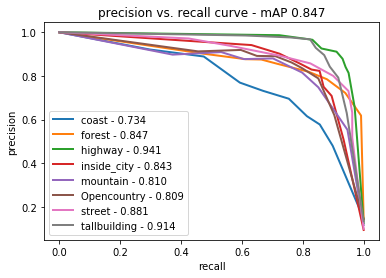

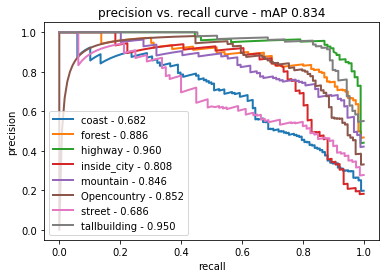

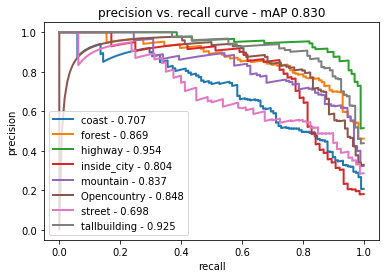

In [26]:
Y = label_binarize(train_labels_cl, classes=[*range(n_classes)])
Y_test = label_binarize(test_labels_cl, classes=[*range(n_classes)])

#KNN classifier
clf = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=8))
clf.fit(train_embeddings_cl, Y)

y_score_knn = clf.predict_proba(test_embeddings_cl)
plot_prec_rec_curve_multiclass(Y_test, y_score_knn, mit_classes)

#SVM classifier
clf_svm = OneVsRestClassifier(SVC(kernel='linear',probability=True))
clf_svm.fit(train_embeddings_cl, Y)

y_score_svm = clf_svm.predict_proba(test_embeddings_cl)
plot_prec_rec_curve_multiclass(Y_test, y_score_svm, mit_classes)


#SVM classifier
clf_svm2 = OneVsRestClassifier(SVC(kernel='rbf',probability=True))
clf_svm2.fit(train_embeddings_cl, Y)

y_score_svm2 = clf_svm2.predict_proba(test_embeddings_cl)
plot_prec_rec_curve_multiclass(Y_test, y_score_svm2, mit_classes)

In [40]:
from MITSplitDataSet import MITSplitDataSet
TRAIN_PATH = '../MIT_split/train_images_filenames.dat'
TRAIN_LABELS_DATA_PATH = '../MIT_split/train_labels.dat'
TEST_PATH = '../MIT_split/test_images_filenames.dat'
TEST_LABELS_DATA_PATH = '../MIT_split/test_labels.dat'
train_data2 = MITSplitDataSet(TRAIN_PATH, TRAIN_LABELS_DATA_PATH, TRANSFORM_IMG)
test_data2 = MITSplitDataSet(TEST_PATH, TEST_LABELS_DATA_PATH, TRANSFORM_IMG)

cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader2 = DataLoader(train_data2, batch_size=64, shuffle=True, **kwargs)
test_loader2 = DataLoader(test_data2, batch_size=64, shuffle=True, **kwargs)

train_dicts = extract_dict_retrieval(train_loader2, model, 256)
test_dicts = extract_dict_retrieval(test_loader2, model, 256)

train_embs = [(f['path'],f['label'],f['emb']) for f in train_dicts]

In [43]:
from tqdm import tqdm
def compute_prec_atK(train_data, test_data, k=5, method=cv2.HISTCMP_BHATTACHARYYA, sortReverse=False):
    precs_per_image = []
    for ind, elem in tqdm(enumerate(test_data)):
        results = getDistances(method, train_data, elem['emb'])
        results = sorted([(v[1], v[0], k) for (k, v) in results.items()], reverse=sortReverse)
        precs_per_image.append((elem['label'], [res[1] for res in results[:k]]))
        # classes = [res[1] for res in results[:k]]
        # precs_per_image.append(classes.count(elem['label']) / k)
    
    return precs_per_image

In [44]:
preds_10 = compute_prec_atK(train_embs, test_dicts,10,cv2.HISTCMP_CORREL,True)
prec_at_1 = np.mean([elem[1][0].count(elem[0]) for elem in preds_10])
prec_at_5 = np.mean([elem[1][:5].count(elem[0]) / 5 for elem in preds_10])
prec_at_10 = np.mean([elem[1][:10].count(elem[0]) / 10 for elem in preds_10])

807it [01:56,  6.93it/s]


In [45]:
print(f'Prec@1: {prec_at_1}', f'Prec@5: {prec_at_5}', f'Prec@10: {prec_at_10}')

Prec@1: 0.8029739776951673 Prec@5: 0.7806691449814126 Prec@10: 0.7716232961586122


# TripletNet

In [46]:
from datasets import TripletMNIST

# Prepare the dataset
train_data = MITSplitDataset_v2(TRAIN_DATA_PATH, TEST_DATA_PATH, transform=TRANSFORM_IMG, train= True)
test_data = MITSplitDataset_v2(TRAIN_DATA_PATH, TEST_DATA_PATH, transform=TRANSFORM_IMG_TEST, train= False)

triplet_train_dataset = TripletMNIST(train_data) # Returns triplet of images and target same/different
triplet_test_dataset = TripletMNIST(test_data)

batch_size = 64
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

printing train data length MIT Split
1881


In [47]:
# Set up the network and training parameters
from networks import ModelM3, TripletNet
from losses import TripletLoss

save_path = 'TripletNet.pth'

embedding_net = ModelM3()
model = TripletNet(embedding_net)

if cuda:
    model.cuda()

if not os.path.exists(save_path):
    if cuda:
        model.cuda()
        print('Cuda!!!')

    margin = 1.
    loss_fn = TripletLoss(margin)
    lr = 1e-3
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.9, last_epoch=-1)
    n_epochs = 100
    log_interval = 1000
    ## Training !!!
    fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)
    torch.save(model.state_dict(), save_path)
else:
    print('Loading model...')
    model.load_state_dict(torch.load(save_path))
    model.to(device)

Cuda!!!
Train: [0/1881 (0%)]	Loss: 1.100309
Epoch: 1/100. Train set: Average loss: 0.9065
Epoch: 1/100. Validation set: Average loss: 0.7547
Train: [0/1881 (0%)]	Loss: 0.650636
Epoch: 2/100. Train set: Average loss: 0.6897
Epoch: 2/100. Validation set: Average loss: 0.6119
Train: [0/1881 (0%)]	Loss: 0.827023
Epoch: 3/100. Train set: Average loss: 0.6418
Epoch: 3/100. Validation set: Average loss: 0.5474
Train: [0/1881 (0%)]	Loss: 0.514813
Epoch: 4/100. Train set: Average loss: 0.5018
Epoch: 4/100. Validation set: Average loss: 0.4526
Train: [0/1881 (0%)]	Loss: 0.558798
Epoch: 5/100. Train set: Average loss: 0.4380
Epoch: 5/100. Validation set: Average loss: 0.4152
Train: [0/1881 (0%)]	Loss: 0.526803
Epoch: 6/100. Train set: Average loss: 0.4273
Epoch: 6/100. Validation set: Average loss: 0.3662
Train: [0/1881 (0%)]	Loss: 0.555103
Epoch: 7/100. Train set: Average loss: 0.3705
Epoch: 7/100. Validation set: Average loss: 0.3530
Train: [0/1881 (0%)]	Loss: 0.204445
Epoch: 8/100. Train set: 

In [23]:
## Visualise input
for X, y in triplet_train_loader:
    print(f"Shape of X [N, C, H, W]: {X[0].shape}")
    print(f"Shape of y: {y}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 256, 256])
Shape of y: []


## Visualise Embedding

In [49]:
from embeddings_utils import *

# Get embedding from train and test
train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model, 256)
test_embeddings_cl, test_labels_cl = extract_embeddings(test_loader, model, 256)

### PCA

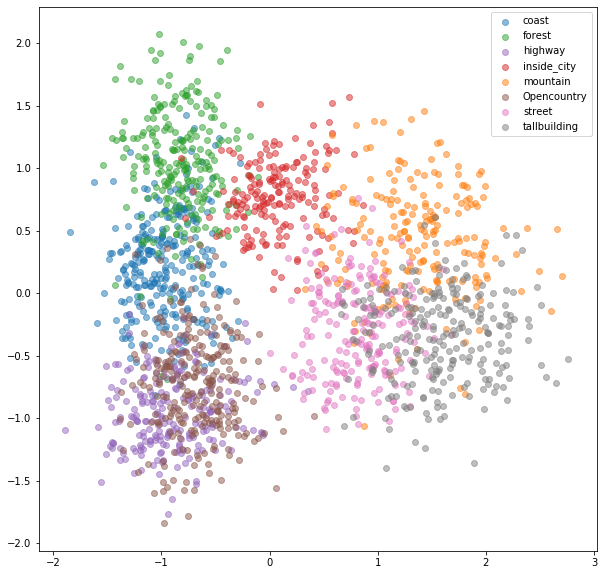

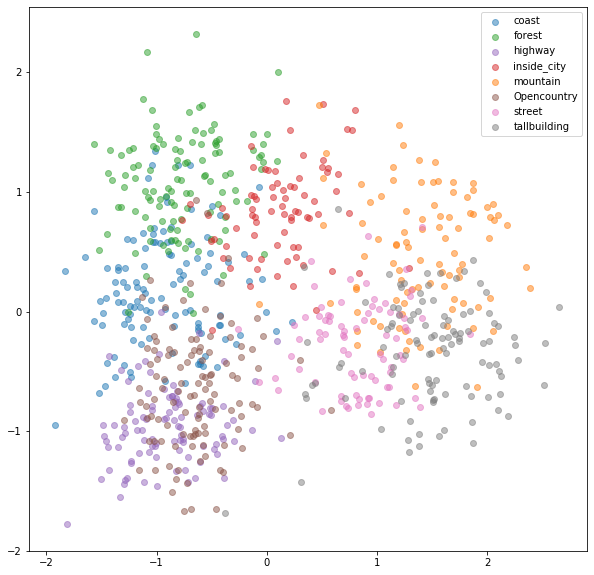

In [26]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
components = pca.fit_transform(train_embeddings_cl)

#train embeddings
plot_embeddings(components, train_labels_cl, mit_classes, colors)

#test embedings
test_comp = pca.transform(test_embeddings_cl)
plot_embeddings(test_comp, test_labels_cl, mit_classes, colors)

### LDA

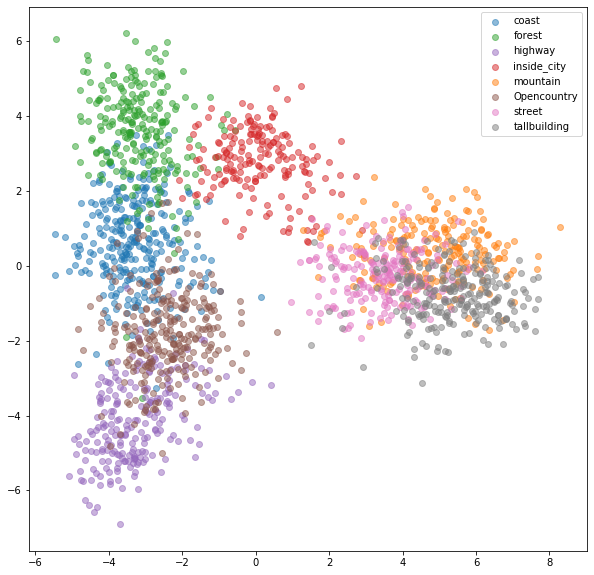

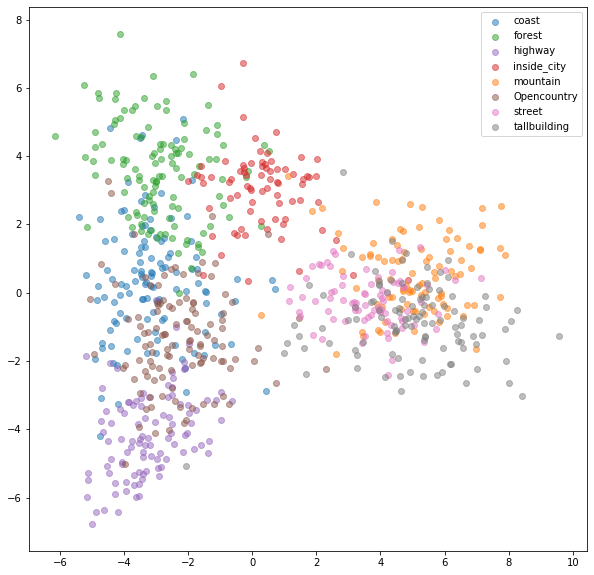

In [27]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda_embs = lda.fit_transform(train_embeddings_cl, train_labels_cl)

#train embeddings
plot_embeddings(lda_embs,train_labels_cl, mit_classes, colors)

#test embeddings
lda_embs_test = lda.transform(test_embeddings_cl)
plot_embeddings(lda_embs_test,test_labels_cl, mit_classes, colors)

### TSNE

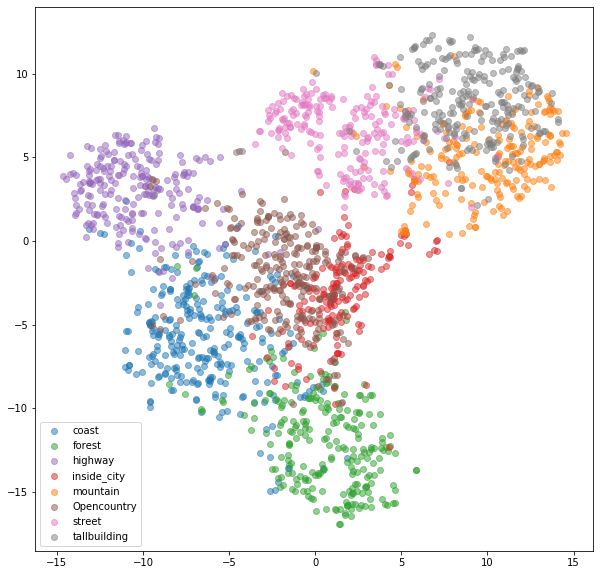

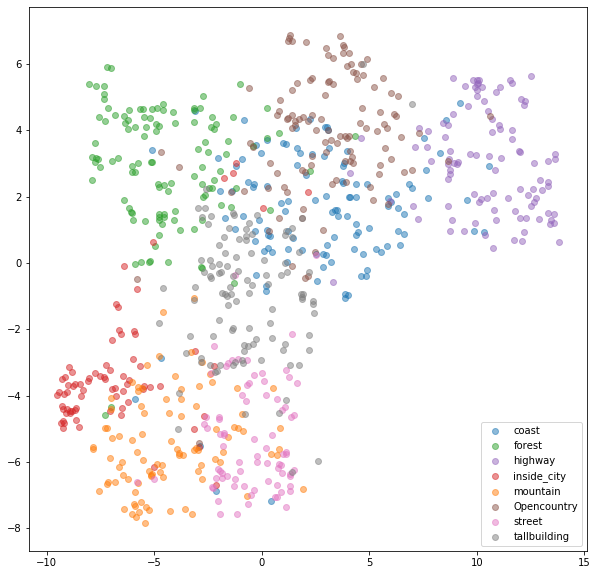

In [51]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, init='random')

embs_reduced = tsne.fit_transform(train_embeddings_cl)
plot_embeddings(embs_reduced,train_labels_cl, mit_classes, colors)

embs_reduced = tsne.fit_transform(test_embeddings_cl)
plot_embeddings(embs_reduced,test_labels_cl, mit_classes, colors)

## Evaluation

In [50]:
knn = build_knn(train_embeddings_cl, train_labels_cl, n_classes)
print('KNN Classifier Accuracy: ',100.0 * knn.score(test_embeddings_cl,test_labels_cl))

KNN Classifier Accuracy:  84.88228004956629


In [30]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# precision recall curve
def plot_prec_rec_curve_multiclass(y_gt, y_pred, labels):
    precision = dict()
    recall = dict()
    aps = []
    for i in range(n_classes):
        ap = average_precision_score(y_gt[:, i], y_pred[:, i])
        aps.append(ap)
        precision[i], recall[i], _ = precision_recall_curve(y_gt[:, i],
                                                            y_pred[:, i])
        plt.plot(recall[i], precision[i], lw=2, label=f'{labels[i]} - {ap:.3f}')
        
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend(loc="best")
    plt.title(f"precision vs. recall curve - mAP {np.mean(aps):.3f}")
    plt.show()

/home/group05/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/group05/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/group05/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/group05/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/group05/anaconda3/lib/

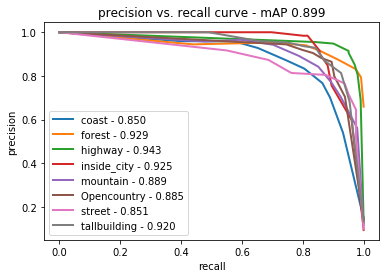

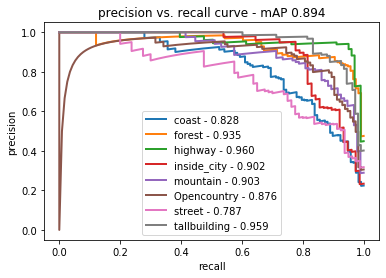

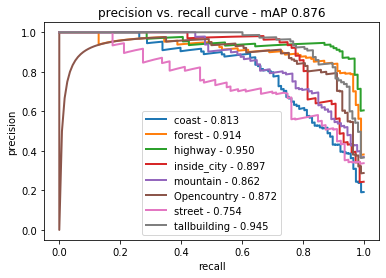

In [31]:
Y = label_binarize(train_labels_cl, classes=[*range(n_classes)])
Y_test = label_binarize(test_labels_cl, classes=[*range(n_classes)])

#KNN classifier
clf = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=8))
clf.fit(train_embeddings_cl, Y)

y_score_knn = clf.predict_proba(test_embeddings_cl)
plot_prec_rec_curve_multiclass(Y_test, y_score_knn, mit_classes)

#SVM classifier
clf_svm = OneVsRestClassifier(SVC(kernel='linear',probability=True))
clf_svm.fit(train_embeddings_cl, Y)

y_score_svm = clf_svm.predict_proba(test_embeddings_cl)
plot_prec_rec_curve_multiclass(Y_test, y_score_svm, mit_classes)


#SVM classifier
clf_svm2 = OneVsRestClassifier(SVC(kernel='rbf',probability=True))
clf_svm2.fit(train_embeddings_cl, Y)

y_score_svm2 = clf_svm2.predict_proba(test_embeddings_cl)
plot_prec_rec_curve_multiclass(Y_test, y_score_svm2, mit_classes)

In [52]:
train_dicts = extract_dict_retrieval(train_loader2, model, 256)
test_dicts = extract_dict_retrieval(test_loader2, model, 256)

train_embs = [(f['path'],f['label'],f['emb']) for f in train_dicts]

preds_10 = compute_prec_atK(train_embs, test_dicts,10,cv2.HISTCMP_CORREL,True)
prec_at_1 = np.mean([elem[1][0].count(elem[0]) for elem in preds_10])
prec_at_5 = np.mean([elem[1][:5].count(elem[0]) / 5 for elem in preds_10])
prec_at_10 = np.mean([elem[1][:10].count(elem[0]) / 10 for elem in preds_10])
print(f'Prec@1: {prec_at_1}', f'Prec@5: {prec_at_5}', f'Prec@10: {prec_at_10}')

807it [01:55,  7.00it/s]

Prec@1: 0.8252788104089219 Prec@5: 0.8074349442379183 Prec@10: 0.799628252788104


## Balanced Batch Sampler

In [32]:
from datasets import BalancedBatchSampler

train_data = MITSplitDataset_v2(TRAIN_DATA_PATH, TEST_DATA_PATH, transform=TRANSFORM_IMG, train= True)
test_data = MITSplitDataset_v2(TRAIN_DATA_PATH, TEST_DATA_PATH, transform=TRANSFORM_IMG_TEST, train= False)

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_data.train_labels, n_classes=8, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_data.test_labels, n_classes=8, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_data, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_data, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineContrastiveLoss
from utils import AllPositivePairSelector, HardNegativePairSelector # Strategies for selecting pairs within a minibatch

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineContrastiveLoss(margin, HardNegativePairSelector())
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 250

printing train data length MIT Split
1881


In [33]:
## Visualise input
for X, y in online_train_loader:
    print(f"Shape of X [N, C, H, W]: {X[0].shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([3, 256, 256])
Shape of y: torch.Size([200]) torch.int64


In [34]:
all_embeddings = fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/1881 (0%)]	Loss: 0.497275
Epoch: 1/20. Train set: Average loss: 6.5102
Epoch: 1/20. Validation set: Average loss: 0.8159
Train: [0/1881 (0%)]	Loss: 0.816220
Epoch: 2/20. Train set: Average loss: 0.6248
Epoch: 2/20. Validation set: Average loss: 0.4893
Train: [0/1881 (0%)]	Loss: 0.507075
Epoch: 3/20. Train set: Average loss: 0.4932
Epoch: 3/20. Validation set: Average loss: 0.4651
Train: [0/1881 (0%)]	Loss: 0.466877
Epoch: 4/20. Train set: Average loss: 0.4653
Epoch: 4/20. Validation set: Average loss: 0.4570
Train: [0/1881 (0%)]	Loss: 0.451848
Epoch: 5/20. Train set: Average loss: 0.4504
Epoch: 5/20. Validation set: Average loss: 0.4524
Train: [0/1881 (0%)]	Loss: 0.438669
Epoch: 6/20. Train set: Average loss: 0.4405
Epoch: 6/20. Validation set: Average loss: 0.4426
Train: [0/1881 (0%)]	Loss: 0.441708
Epoch: 7/20. Train set: Average loss: 0.4350
Epoch: 7/20. Validation set: Average loss: 0.4426
Train: [0/1881 (0%)]	Loss: 0.431226
Epoch: 8/20. Train set: Average loss: 0.4295
Ep

In [35]:
train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_cl, train_labels_cl)
val_embeddings_cl, val_labels_cl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_cl, val_labels_cl)

TypeError: extract_embeddings() missing 1 required positional argument: 'size'